In [1]:
import pandas as pd
import numpy as np
import glob
import sys
import os

import matplotlib.pyplot as plt
import seaborn as sns

root_dir = '/oak/stanford/groups/horence/rob/isoform_localizations/'

sys.path.append(os.path.join(root_dir,'scripts'))
import spatial_utils
import plot_utils

# Introduction to the available data

From MERFISH we have the coordinates and RNA identity of spots in cells

We also have the cell boundary information

We have done behind-the-scenes filtering to use just cells that have the top 90-th percentile number of total spots

This was done to remove cells that have too few spots and might give strange artifacts

After doing this we are left with 23,751 cells, and 252 unique genes

In [2]:
#Use the previously subsampled cells in the q90
spots = pd.read_csv('../processed_data/q90_rna_spots.csv')
cells = pd.read_csv('../processed_data/q90_cells.csv')

In [3]:
#each row in the spots table gives coordinates, gene identity, cell_id, and sample
spots.head()

,global_x,global_y,global_z,target_molecule_name,num_assigned_cells,cell_id,sample
0,-4237.7397,1681.8490,0.0,Acta2,1,217951229059897556843731256135790480948,mouse1sample2
1,-4215.4233,1699.2443,0.0,Acta2,1,271699149458331512543397347819513343392,mouse1sample2
2,-4207.3945,1706.8620,0.0,Acta2,1,271699149458331512543397347819513343392,mouse1sample2
3,-4206.7200,1711.7010,0.0,Acta2,1,271699149458331512543397347819513343392,mouse1sample2
4,-4270.8410,1726.0154,0.0,Acta2,1,29559620824861669263446897425219499530,mouse1sample2


In [4]:
#each row in the cells table has the cell_id, sample info, and x,y coordinates that specify the cell boundary
#almost exclusively use the cells table for the boundary info
cells.head()

,cell_id,boundaryX,boundaryY,slice_id,sample
0,102513782275574352391549636869222584212,"2097.1362953431903, 2097.1362953431903, 2097.1...","2346.248493306339, 2345.705993324518, 2345.163...",mouse2_slice10,mouse2sample2
1,198259986845326386185083518576166673028,"2106.141795041412, 2106.141795041412, 2106.141...","2328.9969938844442, 2328.4544939026237, 2327.9...",mouse2_slice10,mouse2sample2
2,202633430165103308157026102881717708611,"2058.727296630293, 2058.727296630293, 2058.727...","2228.8514972403646, 2228.308997258544, 2227.76...",mouse2_slice10,mouse2sample2
3,202866835269971649617924499544299592196,"2055.3637967430054, 2055.3637967430054, 2055.2...","2248.4899965822697, 2247.947496600449, 2247.51...",mouse2_slice10,mouse2sample2
4,21014129563353280159906900457364829387,"2096.1597953759133, 2096.1597953759133, 2096.0...","2310.4434945061803, 2309.9009945243597, 2309.4...",mouse2_slice10,mouse2sample2


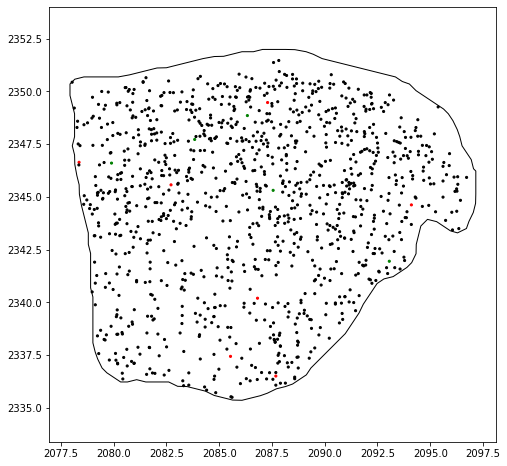

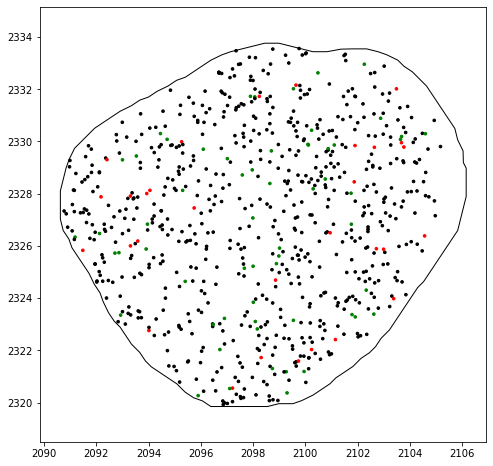

In [26]:
cell_ids = [
    '102513782275574352391549636869222584212',
    '198259986845326386185083518576166673028',
]

plot_spots = spots[spots['cell_id'].isin(cell_ids)]
plot_cells = cells[cells['cell_id'].isin(cell_ids)]

plots = plot_utils.plot_spot_cells(
    plot_spots, 
    plot_cells,
    spot_colors = {'Adra1b':'red','C1ql3':'green'}
)
for fig,ax in plots:
    plt.show()
    plt.close()

In [8]:
#There are 22 million spots over all the cells
spots.shape[0]

22663571

In [5]:
#There are 252 unique genes in the data
spots['target_molecule_name'].unique().size

252

In [6]:
#~23,000 unique cells
spots['cell_id'].unique().size

23751

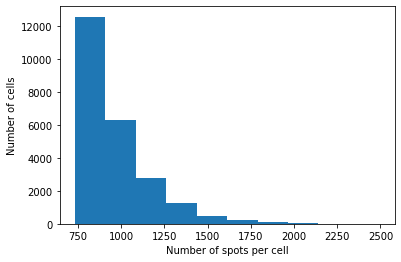

In [10]:
spots.groupby('cell_id').size().plot.hist()
plt.xlabel('Number of spots per cell')
plt.ylabel('Number of cells')
plt.show()
plt.close()

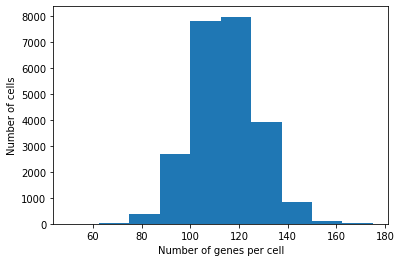

In [11]:
spots.groupby('cell_id')['target_molecule_name'].unique().apply(len).plot.hist()
plt.xlabel('Number of genes per cell')
plt.ylabel('Number of cells')
plt.show()
plt.close()

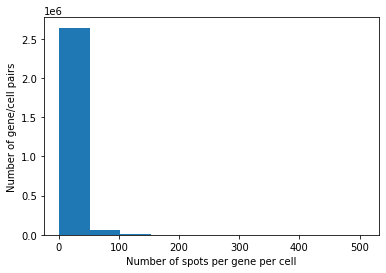

In [27]:
spots.groupby(['cell_id','target_molecule_name']).size().plot.hist()
plt.xlabel('Number of spots per gene per cell')
plt.ylabel('Number of gene/cell pairs')
plt.show()
plt.close()

# Identifying genes that are peripheral in individual cells

Process for each cell is to:
1. Calculate the min-distance of each spot to the cell boundary
2. Rank the spots from 1 to n in order of min-distance. n is the number of spots in that cell
3. Normalize the ranks to be between 0 and 1 by dividing by n. This is to allow comparisons between cells with different numbers of spots
4. For each gene in that cell, determine the median of the normalized ranks
5. That median is the periphery score for that gene in that cell

Below is an example looking at just 3 genes in a single cell

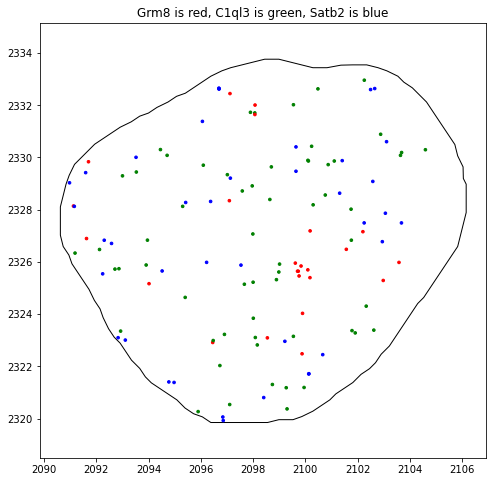

In [60]:
cell_id = '198259986845326386185083518576166673028'

spot_colors = {
    'Grm8':'red',
    'C1ql3':'green',
    'Satb2':'blue',
}

example_spots = spots[spots['cell_id'].eq(cell_id) & spots['target_molecule_name'].isin(spot_colors.keys())]
example_cells = cells[cells['cell_id'].eq(cell_id)]

plots = plot_utils.plot_spot_cells(
    example_spots, 
    example_cells,
    spot_colors,
)
for fig,ax in plots:
    plt.title(', '.join(['{} is {}'.format(g,c) for g,c in spot_colors.items()]))
    plt.show()
    plt.close()

In [61]:
spot_dists = spatial_utils.calculate_spot_to_boundary_min_dist(example_spots, example_cells)
spot_dists = spot_dists[['target_molecule_name','min_boundary_dist']]
spot_dists['rank'] = spot_dists['min_boundary_dist'].rank()
spot_dists['normalized_rank'] = spot_dists['rank']/spot_dists.shape[0]
spot_dists

,target_molecule_name,min_boundary_dist,rank,normalized_rank
4167646,C1ql3,2.911587,73.0,0.588710
4167647,C1ql3,6.002563,124.0,1.000000
4167648,C1ql3,3.027280,76.0,0.612903
4167842,Grm8,2.117340,63.0,0.508065
4168222,Satb2,4.461762,107.0,0.862903
...,...,...,...,...
4179251,Satb2,0.572503,16.0,0.129032
4180076,C1ql3,0.669556,20.0,0.161290
4180078,C1ql3,2.656314,68.0,0.548387
4180821,Satb2,1.246984,33.0,0.266129


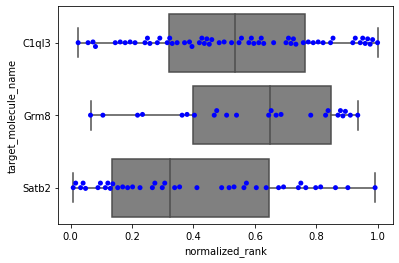

In [64]:
sns.boxplot(
    x = 'normalized_rank',
    y = 'target_molecule_name',
    color = 'grey',
    data = spot_dists,
)

sns.swarmplot(
    x = 'normalized_rank',
    y = 'target_molecule_name',
    color = 'blue',
    data = spot_dists,
)
plt.show()
plt.close()

# Finding genes that are consistently peripheral across cells


Have potential concerns where lower number of spots of a gene in a cell results in more extreme scores

Genes like Ctss standout as being peripheral, while genes like Col24a1 are central



In [78]:
periph_df = pd.read_csv('../processed_data/20210127_q90_cell_gene_med_norm_ranks.csv')

cell_gene_spot_nums = spots.groupby(['cell_id','target_molecule_name']).size()

periph_df = periph_df.set_index(['cell_id','target_molecule_name'])
periph_df['gene_spot_counts'] = cell_gene_spot_nums
periph_df = periph_df.reset_index()

periph_df.head()

,cell_id,target_molecule_name,normalized_rank,clust_id,gene_spot_counts
0,100024126192764500990464846159908804485,1700022I11Rik,0.048751,9,1
1,100024126192764500990464846159908804485,Acta2,0.894768,9,4
2,100024126192764500990464846159908804485,Adam2,0.752675,9,1
3,100024126192764500990464846159908804485,Adamts4,0.859691,9,1
4,100024126192764500990464846159908804485,Adra1b,0.325208,9,26


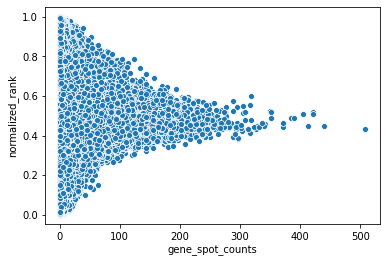

In [79]:
sns.scatterplot(
    x = 'gene_spot_counts',
    y = 'normalized_rank',
    data = periph_df,
)

plt.show()
plt.close()

In [81]:
#Lets filter out gene/cell pairs with less than 10 spots
#Then find which genes have low median periph scores over all cells

med_periph_over_cells = (
    periph_df[
        periph_df['gene_spot_counts'].ge(10)
    ]
    .groupby('target_molecule_name')
    ['normalized_rank']
    .agg(
        num_cells='count',
        median_periph_score='median',
    )
    .sort_values('median_periph_score')
)

med_periph_over_cells

,num_cells,median_periph_score
target_molecule_name,,
Ctss,542,0.242999
Gfap,224,0.341080
Aqp4,275,0.370546
Pdgfra,281,0.380901
Clrn1,1,0.394338
...,...,...
Teddm3,153,0.741379
Lama3,285,0.758488
Ccnb1,1,0.760638


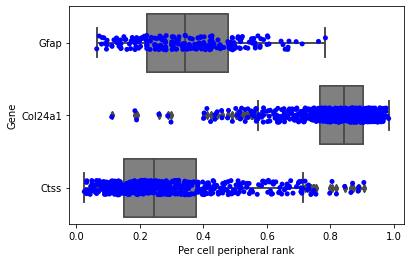

In [87]:
plot_df = periph_df[
    periph_df['gene_spot_counts'].ge(10) &
    periph_df['target_molecule_name'].isin([
        'Ctss',
        'Gfap',
        'Col24a1',
    ])
]

sns.boxplot(
    x = 'normalized_rank',
    y = 'target_molecule_name',
    color = 'grey',
    data = plot_df,
)

sns.stripplot(
    x = 'normalized_rank',
    y = 'target_molecule_name',
    color = 'blue',
    #alpah = 0.5,
    data = plot_df,
)

plt.ylabel('Gene')
plt.xlabel('Per cell peripheral rank')
plt.show()
plt.close()

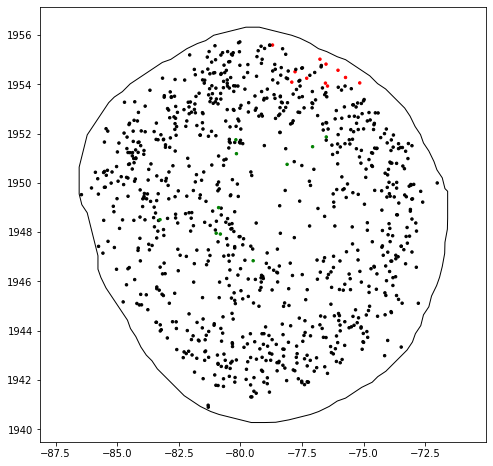

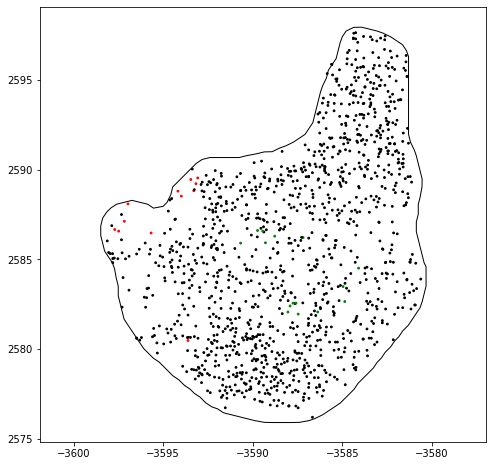

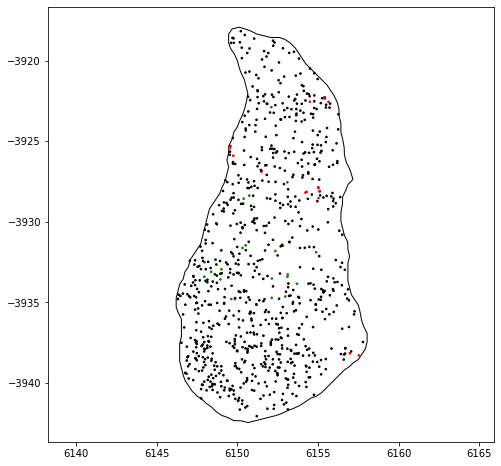

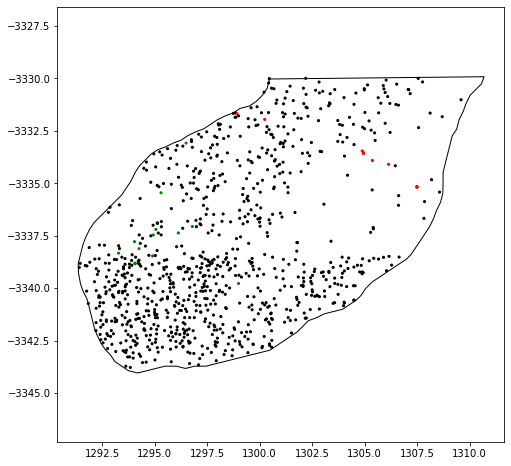

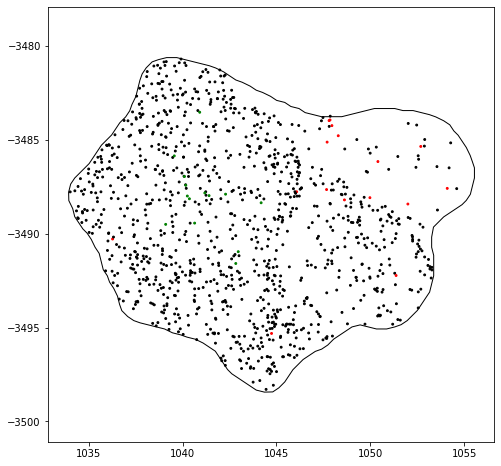

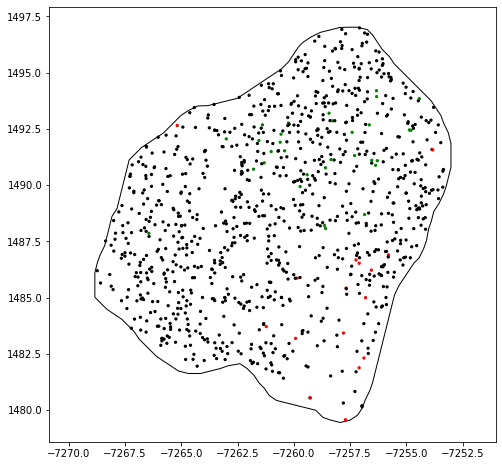

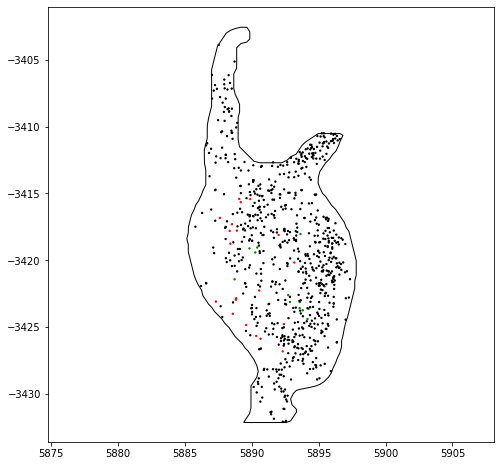

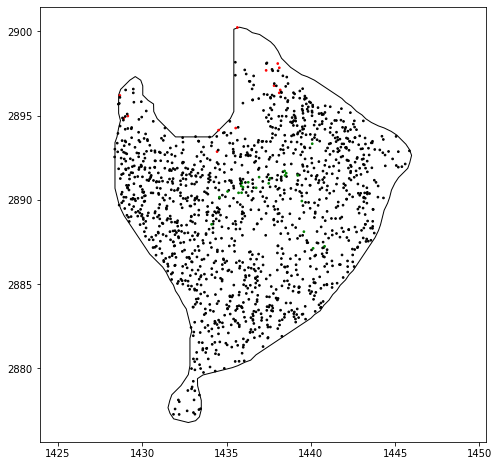

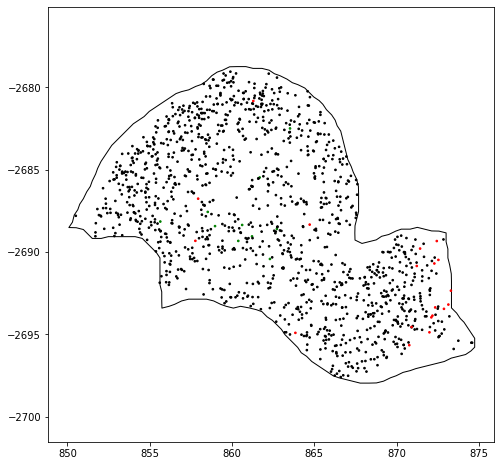

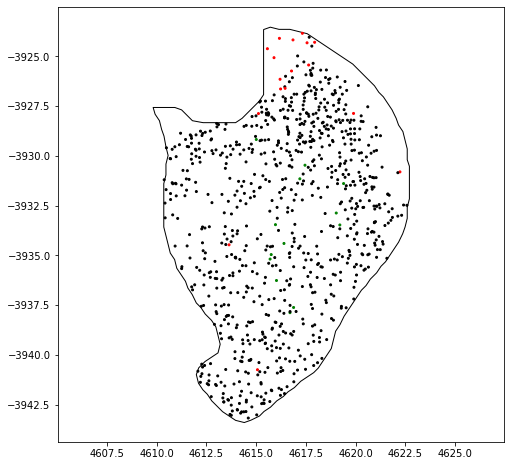

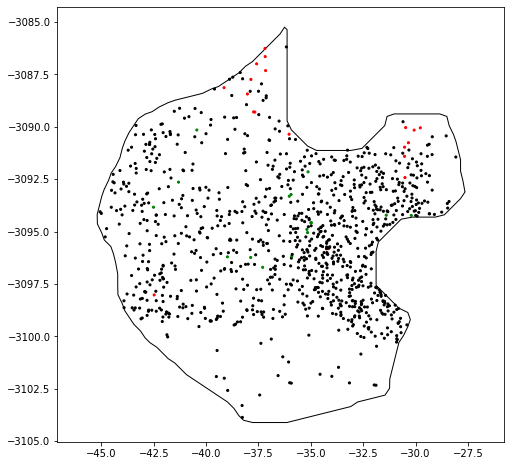

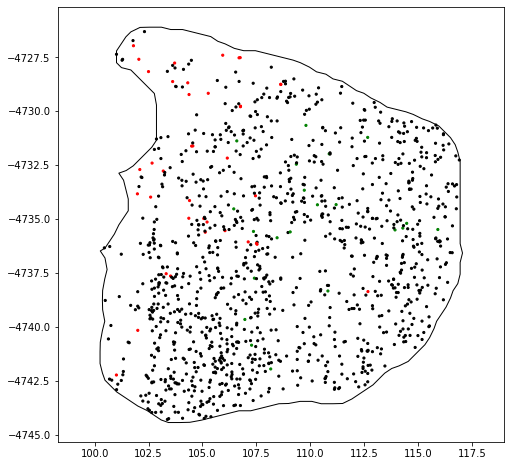

In [91]:
#Finding cells that have at least 10 counts of Ctss, and 10 of Col24a1 for plotting
cell_ids = (
    spots.groupby('cell_id').filter(
        lambda g: 
            (g['target_molecule_name'].eq('Ctss').sum() >= 10) &
            (g['target_molecule_name'].eq('Col24a1').sum() >= 10)
    )
    ['cell_id'].unique()
)

plot_spots = spots[spots['cell_id'].isin(cell_ids)]
plot_cells = cells[cells['cell_id'].isin(cell_ids)]

plots = plot_utils.plot_spot_cells(
    plot_spots, 
    plot_cells,
    spot_colors = {'Ctss':'red','Col24a1':'green'}
)
for fig,ax in plots:
    plt.show()
    plt.close()

# How do we know that a gene is more peripheral than it would be by chance?

We can swap the gene labels of cells by doing permutations, and seeing how often the random-labeled genes are more peripheral than the real-labeled genes

We can use the same example as last time

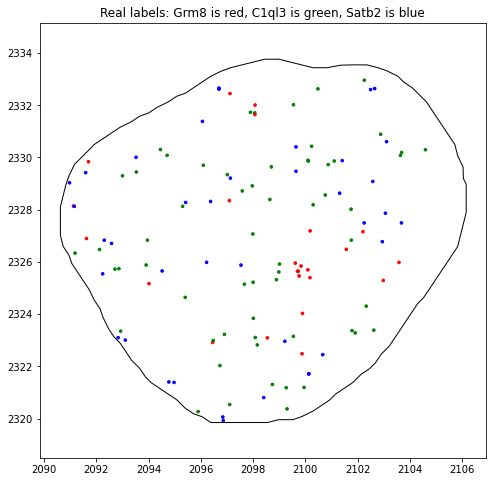

In [105]:
cell_id = '198259986845326386185083518576166673028'

spot_colors = {
    'Grm8':'red',
    'C1ql3':'green',
    'Satb2':'blue',
}

example_spots = spots[spots['cell_id'].eq(cell_id) & spots['target_molecule_name'].isin(spot_colors.keys())]
example_cells = cells[cells['cell_id'].eq(cell_id)]

plots = plot_utils.plot_spot_cells(
    example_spots, 
    example_cells,
    spot_colors,
)
for fig,ax in plots:
    plt.title('Real labels: '+', '.join(['{} is {}'.format(g,c) for g,c in spot_colors.items()]))
    plt.show()
    plt.close()

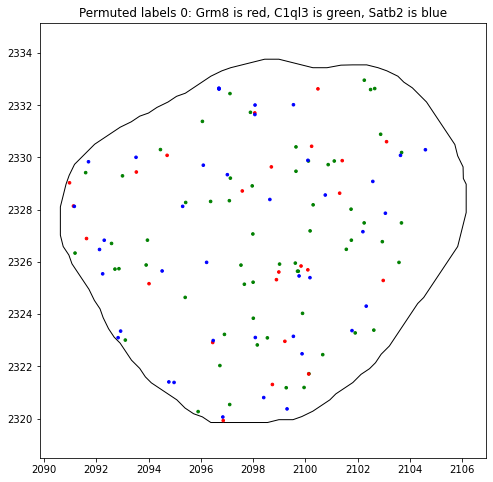

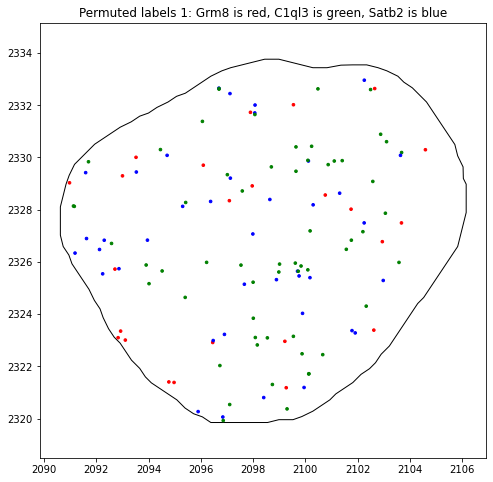

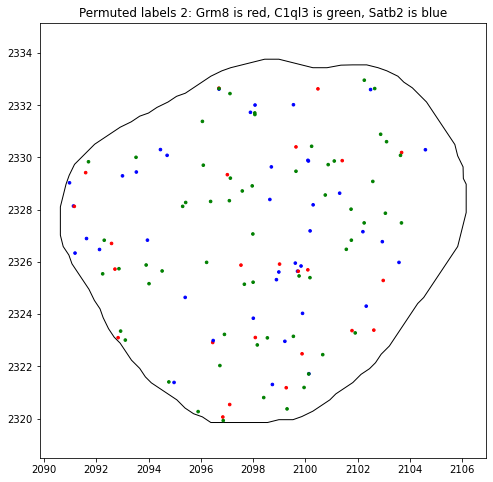

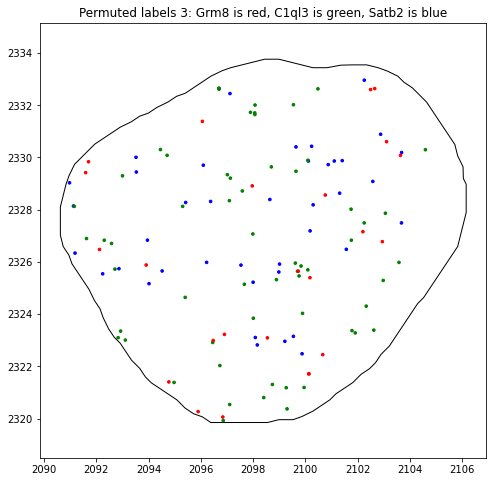

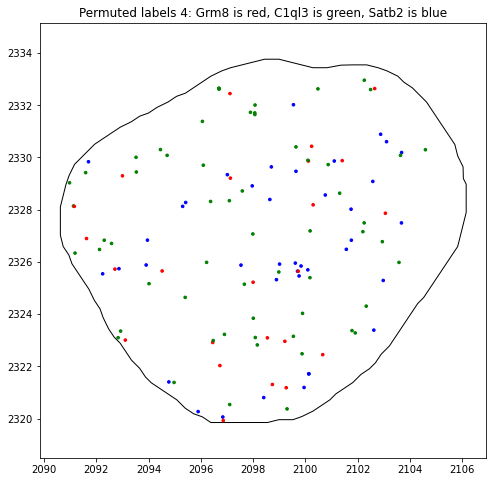

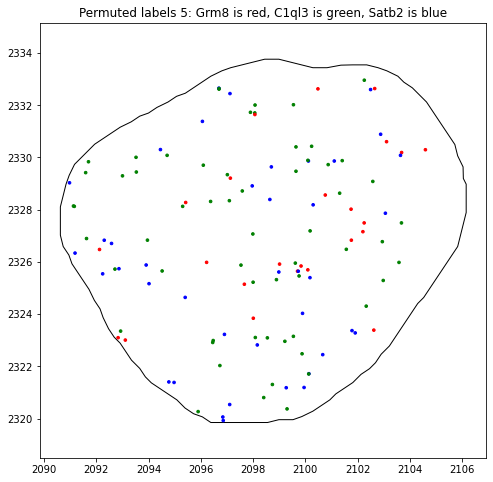

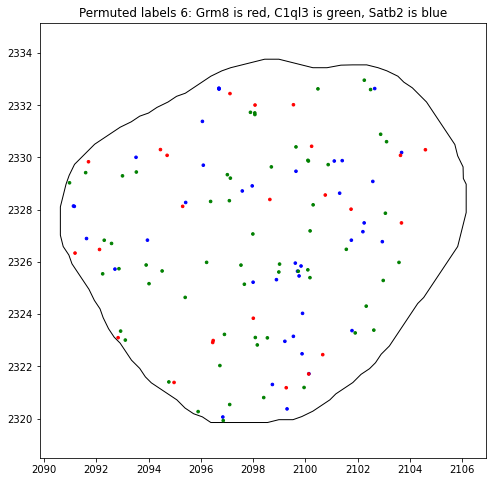

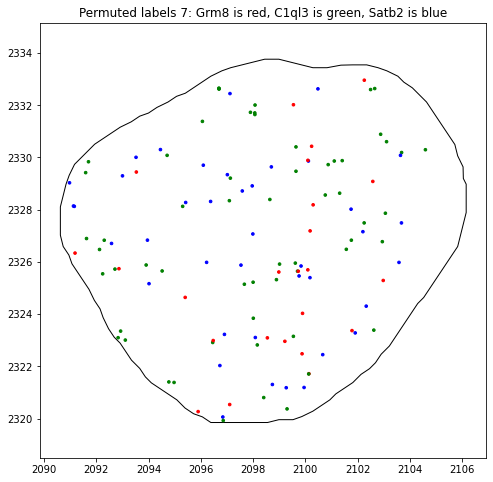

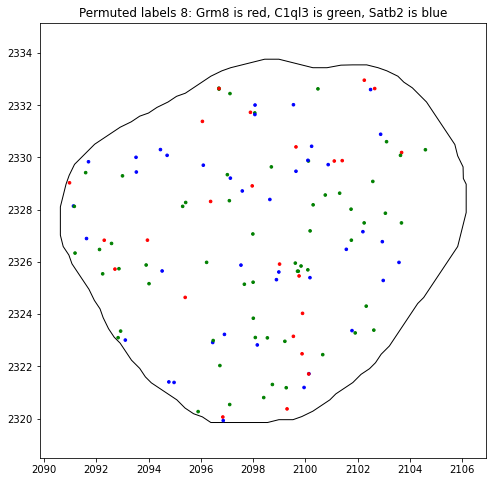

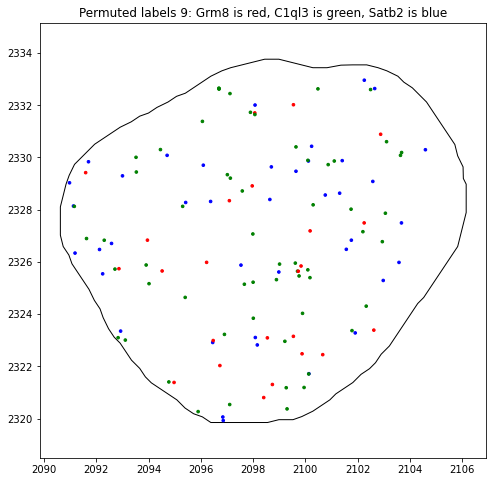

In [107]:
real_labels = example_spots['target_molecule_name']

num_its = 10
perm_med_dists = pd.DataFrame()

for i in range(num_its):
    shuffled_genes = (
        np.random.choice(
            example_spots['target_molecule_name'],
            example_spots.shape[0],
            replace=False
        )
    )

    example_spots['target_molecule_name'] = shuffled_genes
    
    spot_dists = spatial_utils.calculate_spot_to_boundary_min_dist(example_spots, example_cells)
    spot_dists = spot_dists[['target_molecule_name','min_boundary_dist']]
    spot_dists['rank'] = spot_dists['min_boundary_dist'].rank()
    spot_dists['normalized_rank'] = spot_dists['rank']/spot_dists.shape[0]
    sub_perm_med_dists = spot_dists.groupby('target_molecule_name')['normalized_rank'].median()
    
    perm_med_dists = pd.concat((perm_med_dists,sub_perm_med_dists),axis=1)

    plots = plot_utils.plot_spot_cells(
        example_spots, 
        example_cells,
        spot_colors,
    )
    for fig,ax in plots:
        plt.title('Permuted labels {}: '.format(i)+', '.join(['{} is {}'.format(g,c) for g,c in spot_colors.items()]))
        plt.show()
        plt.close()
        
example_spots['target_molecule_name'] = real_labels

In [108]:
perm_med_dists

,normalized_rank,normalized_rank,normalized_rank,normalized_rank,normalized_rank,normalized_rank,normalized_rank,normalized_rank,normalized_rank,normalized_rank
target_molecule_name,,,,,,,,,,
C1ql3,0.592742,0.600806,0.540323,0.407258,0.447581,0.536290,0.504032,0.483871,0.520161,0.500000
Grm8,0.500000,0.346774,0.395161,0.407258,0.512097,0.697581,0.395161,0.556452,0.455645,0.524194
Satb2,0.395161,0.439516,0.487903,0.604839,0.681452,0.350806,0.572581,0.512097,0.487903,0.467742


In [123]:
spot_dists = spatial_utils.calculate_spot_to_boundary_min_dist(example_spots, example_cells)
spot_dists = spot_dists[['target_molecule_name','min_boundary_dist']]
spot_dists['rank'] = spot_dists['min_boundary_dist'].rank()
spot_dists['normalized_rank'] = spot_dists['rank']/spot_dists.shape[0]
real_scores = spot_dists.groupby('target_molecule_name')['normalized_rank'].median().reset_index()
real_scores['source'] = 'observed'
real_scores

,target_molecule_name,normalized_rank,source
0,C1ql3,0.500000,observed
1,Grm8,0.524194,observed
2,Satb2,0.467742,observed


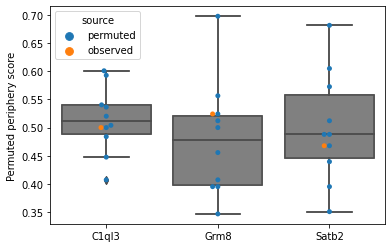

In [127]:
plot_data = perm_med_dists.reset_index().melt(
    id_vars='target_molecule_name',
    value_name='normalized_rank',
    var_name='source',
)
plot_data['source'] = 'permuted'

sns.boxplot(
    x = 'target_molecule_name',
    y = 'normalized_rank',
    color = 'grey',
    data = plot_data,
)

plot_data = pd.concat((plot_data, real_scores))
sns.swarmplot(
    x = 'target_molecule_name',
    y = 'normalized_rank',
    hue = 'source',
    data = plot_data,
)
plt.xlabel('')
plt.ylabel('Permuted periphery score')

plt.show()
plt.close()

# Followup questions

1. How can we test if a gene is more peripheral than chance over all cells?

2. Can we find genes which have different peripheral localization patterns in different cells? (certain cell-types?)


We can answer (1) by asking if the median periphery score of a gene across all cells is more peripheral than expected by chance. The null in this case is 


In [2]:
df = pd.read_csv('../processed_data/20210128_combined_perm_over_cells.csv')
df.head()

,gene,Cldn5,Col24a1,Blank-9,Camk2d,Plcxd3,Ankfn1,Blank-8,C1qtnf7,Egr2,...,Marcksl1,Dscaml1,Vtn,Slc44a5,Tmtc2,Ccnb1,Cacng5,Blank-3,Fam84b,Fezf2
0,num_cells,3238.000000,6403.000000,4251.000000,19781.000000,14157.000000,5514.000000,5270.000000,1938.000000,10508.000000,...,13290.000000,19984.000000,7076.000000,9060.000000,15638.000000,4087.000000,8732.000000,3975.000000,12811.000000,13034.000000
1,real_Q25,0.109027,0.621071,0.357121,0.382998,0.343750,0.383723,0.309889,0.323393,0.439124,...,0.297070,0.396678,0.226887,0.404934,0.348687,0.338986,0.323808,0.414308,0.345384,0.380055
2,real_Q50,0.345253,0.805838,0.621622,0.480506,0.492739,0.587525,0.557525,0.596202,0.659840,...,0.429504,0.513833,0.477407,0.621212,0.544590,0.599781,0.512613,0.659731,0.516213,0.500000
3,real_Q75,0.660303,0.905948,0.831739,0.575935,0.636757,0.789254,0.795863,0.833018,0.832745,...,0.547651,0.627884,0.720179,0.807268,0.723620,0.820092,0.701991,0.854632,0.673526,0.613082
4,overall_clusts_lt_count_Q25,0.000000,1000.000000,1000.000000,0.000000,0.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,0.000000,431.000000,0.000000,1000.000000,1000.000000,1000.000000,47.000000,1000.000000,121.000000,0.000000


In [3]:
df.head(10)

,gene,Cldn5,Col24a1,Blank-9,Camk2d,Plcxd3,Ankfn1,Blank-8,C1qtnf7,Egr2,...,Marcksl1,Dscaml1,Vtn,Slc44a5,Tmtc2,Ccnb1,Cacng5,Blank-3,Fam84b,Fezf2
0,num_cells,3238.000000,6403.000000,4251.000000,19781.000000,14157.000000,5514.000000,5270.000000,1938.000000,10508.000000,...,13290.000000,19984.000000,7076.000000,9060.000000,15638.000000,4087.000000,8732.000000,3975.000000,12811.000000,13034.000000
1,real_Q25,0.109027,0.621071,0.357121,0.382998,0.343750,0.383723,0.309889,0.323393,0.439124,...,0.297070,0.396678,0.226887,0.404934,0.348687,0.338986,0.323808,0.414308,0.345384,0.380055
2,real_Q50,0.345253,0.805838,0.621622,0.480506,0.492739,0.587525,0.557525,0.596202,0.659840,...,0.429504,0.513833,0.477407,0.621212,0.544590,0.599781,0.512613,0.659731,0.516213,0.500000
3,real_Q75,0.660303,0.905948,0.831739,0.575935,0.636757,0.789254,0.795863,0.833018,0.832745,...,0.547651,0.627884,0.720179,0.807268,0.723620,0.820092,0.701991,0.854632,0.673526,0.613082
4,overall_clusts_lt_count_Q25,0.000000,1000.000000,1000.000000,0.000000,0.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,0.000000,431.000000,0.000000,1000.000000,1000.000000,1000.000000,47.000000,1000.000000,121.000000,0.000000
5,overall_clusts_lt_count_Q50,0.000000,1000.000000,1000.000000,0.000000,1.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,0.000000,1000.000000,0.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,574.000000
6,overall_clusts_lt_count_Q75,0.000000,1000.000000,1000.000000,0.000000,59.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,0.000000,1000.000000,878.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
7,overall_clusts_Q25,0.306325,0.323705,0.262918,0.409314,0.357920,0.304409,0.266667,0.263368,0.296028,...,0.382246,0.396938,0.284251,0.290672,0.324684,0.264222,0.330335,0.261452,0.348878,0.392960
8,overall_clusts_Q50,0.499831,0.499397,0.499337,0.499454,0.499444,0.499492,0.499456,0.499094,0.499483,...,0.499443,0.499424,0.499371,0.499584,0.499439,0.499363,0.499362,0.499488,0.499401,0.499421
9,overall_clusts_Q75,0.693521,0.675096,0.735154,0.589642,0.640853,0.694633,0.732275,0.736197,0.703259,...,0.616726,0.601899,0.714459,0.708845,0.674421,0.734488,0.668486,0.737385,0.650104,0.605999


In [9]:
df = df.set_index('gene')

In [10]:
df.head(10)

,Cldn5,Col24a1,Blank-9,Camk2d,Plcxd3,Ankfn1,Blank-8,C1qtnf7,Egr2,Ikzf2,...,Marcksl1,Dscaml1,Vtn,Slc44a5,Tmtc2,Ccnb1,Cacng5,Blank-3,Fam84b,Fezf2
gene,,,,,,,,,,,,,,,,,,,,,
num_cells,3238.000000,6403.000000,4251.000000,19781.000000,14157.000000,5514.000000,5270.000000,1938.000000,10508.000000,10379.000000,...,13290.000000,19984.000000,7076.000000,9060.000000,15638.000000,4087.000000,8732.000000,3975.000000,12811.000000,13034.000000
real_Q25,0.109027,0.621071,0.357121,0.382998,0.343750,0.383723,0.309889,0.323393,0.439124,0.381283,...,0.297070,0.396678,0.226887,0.404934,0.348687,0.338986,0.323808,0.414308,0.345384,0.380055
real_Q50,0.345253,0.805838,0.621622,0.480506,0.492739,0.587525,0.557525,0.596202,0.659840,0.602165,...,0.429504,0.513833,0.477407,0.621212,0.544590,0.599781,0.512613,0.659731,0.516213,0.500000
real_Q75,0.660303,0.905948,0.831739,0.575935,0.636757,0.789254,0.795863,0.833018,0.832745,0.798409,...,0.547651,0.627884,0.720179,0.807268,0.723620,0.820092,0.701991,0.854632,0.673526,0.613082
overall_clusts_lt_count_Q25,0.000000,1000.000000,1000.000000,0.000000,0.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,0.000000,431.000000,0.000000,1000.000000,1000.000000,1000.000000,47.000000,1000.000000,121.000000,0.000000
overall_clusts_lt_count_Q50,0.000000,1000.000000,1000.000000,0.000000,1.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,0.000000,1000.000000,0.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,574.000000
overall_clusts_lt_count_Q75,0.000000,1000.000000,1000.000000,0.000000,59.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,0.000000,1000.000000,878.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
overall_clusts_Q25,0.306325,0.323705,0.262918,0.409314,0.357920,0.304409,0.266667,0.263368,0.296028,0.297960,...,0.382246,0.396938,0.284251,0.290672,0.324684,0.264222,0.330335,0.261452,0.348878,0.392960
overall_clusts_Q50,0.499831,0.499397,0.499337,0.499454,0.499444,0.499492,0.499456,0.499094,0.499483,0.499394,...,0.499443,0.499424,0.499371,0.499584,0.499439,0.499363,0.499362,0.499488,0.499401,0.499421


In [11]:
df.loc['overall_clusts_lt_count_Q50'].values

array([   0., 1000., 1000.,    0.,    1., 1000., 1000., 1000., 1000.,
       1000., 1000.,    0., 1000.,    0.,    0., 1000., 1000.,    0.,
       1000., 1000., 1000., 1000.,    0., 1000., 1000., 1000., 1000.,
       1000.,  996.,    0.,    0., 1000., 1000., 1000., 1000., 1000.,
       1000.,  990., 1000., 1000.,  998.,    0., 1000., 1000., 1000.,
        851., 1000.,    0.,    0.,    0., 1000.,    0.,    0.,    0.,
          0., 1000.,    0.,    0., 1000.,    0.,  999., 1000., 1000.,
       1000., 1000.,    0., 1000., 1000.,    0.,    0., 1000.,  569.,
          0., 1000.,    0., 1000., 1000.,    0.,    0., 1000., 1000.,
          4.,    0.,    0., 1000.,    0.,    0., 1000.,    0.,    0.,
       1000., 1000., 1000., 1000., 1000., 1000.,    6., 1000., 1000.,
          0., 1000.,    0.,    0., 1000., 1000., 1000., 1000., 1000.,
       1000.,    0.,    0., 1000.,    0.,    0., 1000., 1000., 1000.,
        810., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,    1.,
       1000., 1000.,

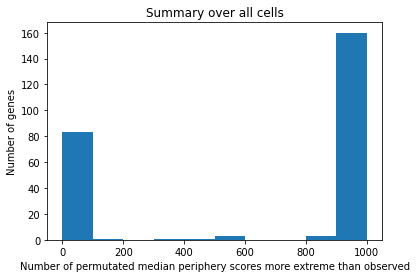

In [15]:
df.loc['overall_clusts_lt_count_Q50'].plot.hist()
plt.title('Summary over all cells')
plt.xlabel('Number of permutated median periphery scores more extreme than observed')
plt.ylabel('Number of genes')
plt.show()
plt.close()

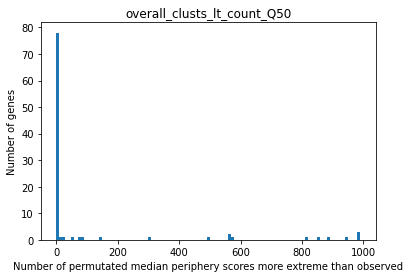

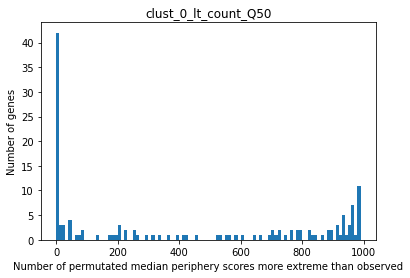

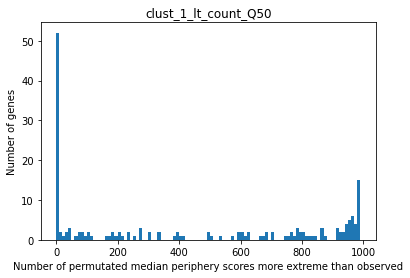

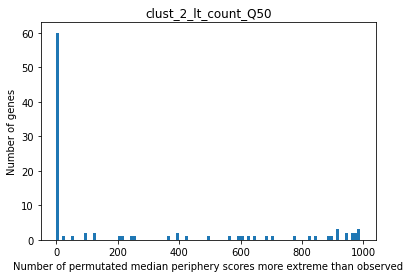

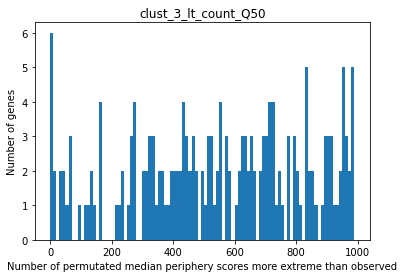

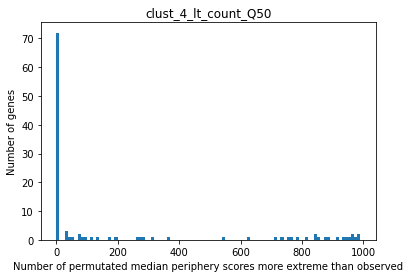

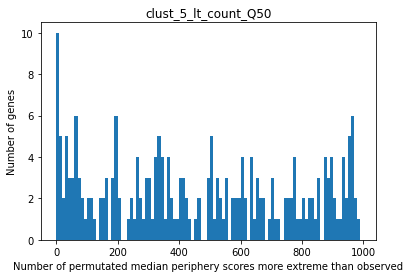

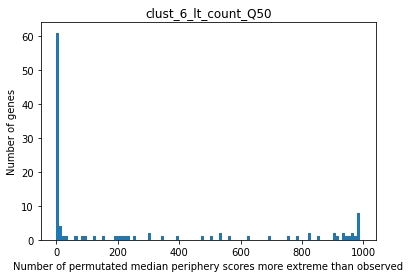

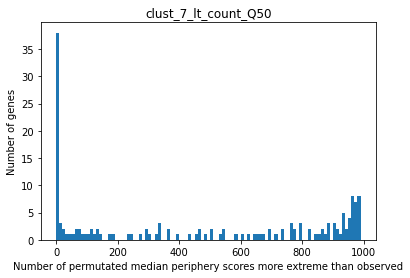

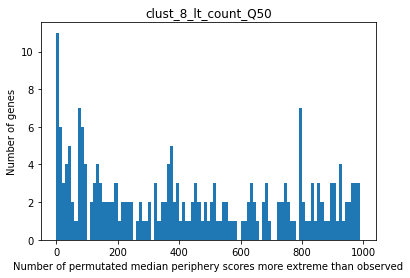

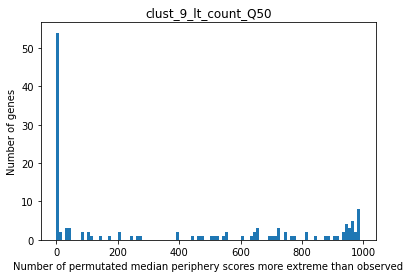

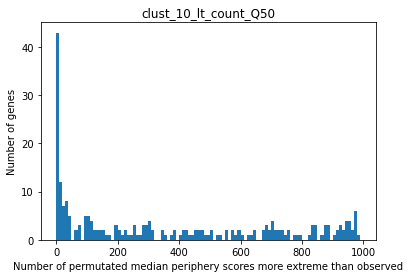

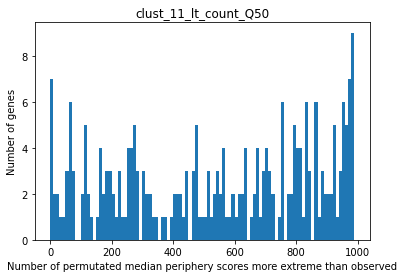

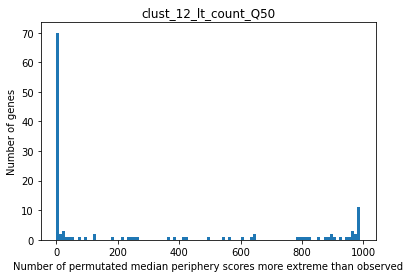

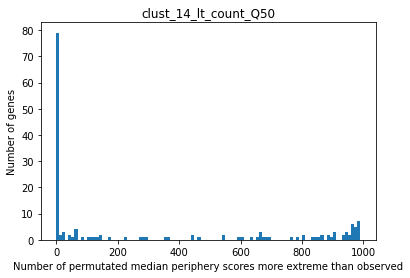

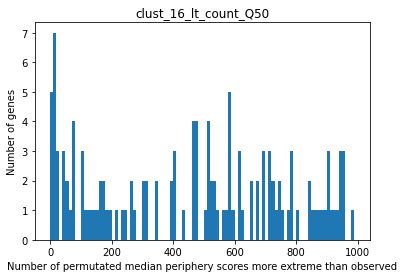

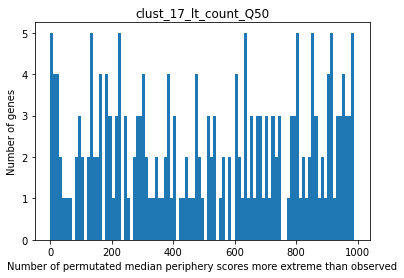

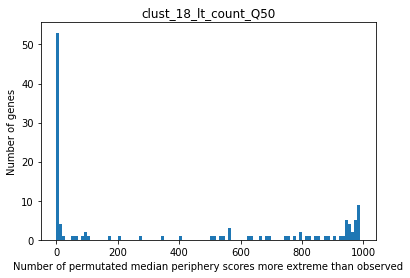

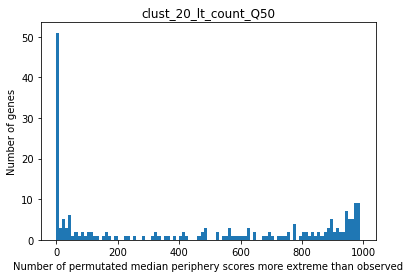

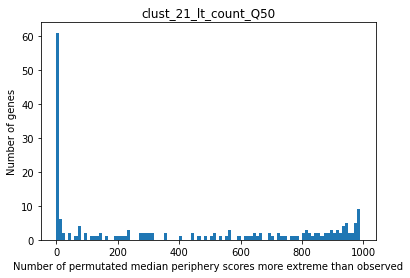

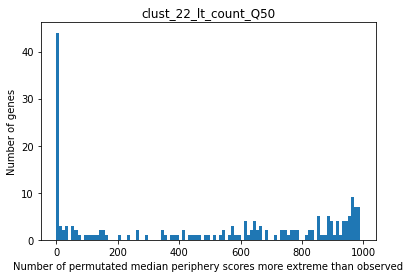

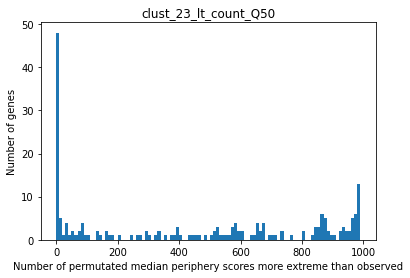

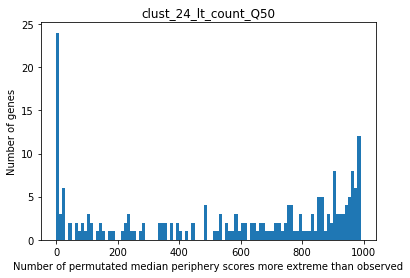

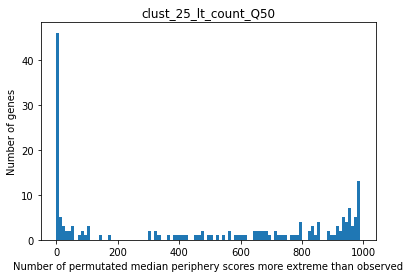

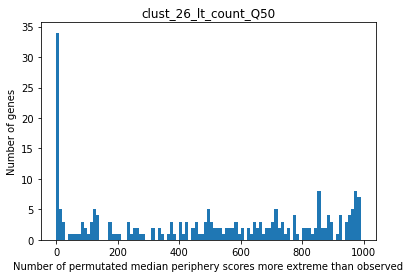

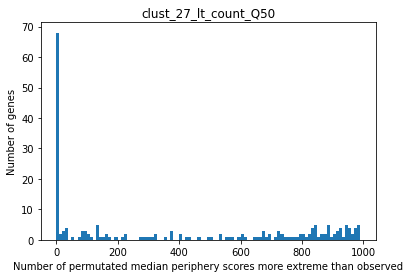

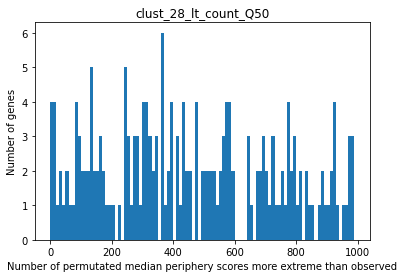

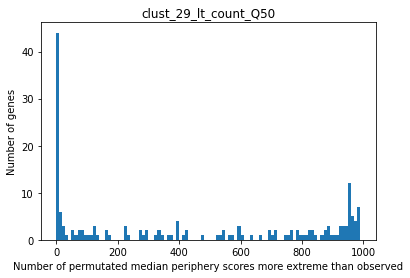

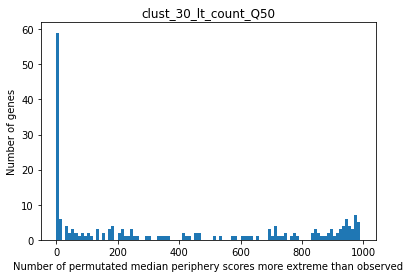

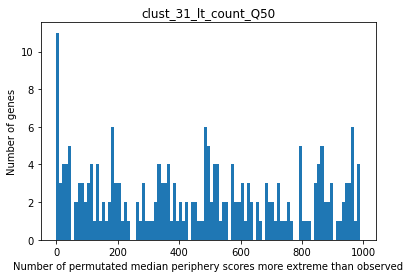

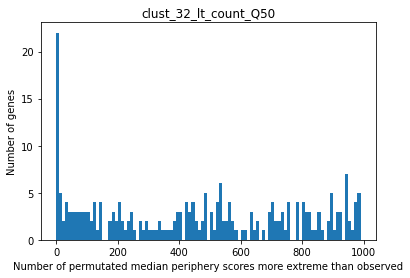

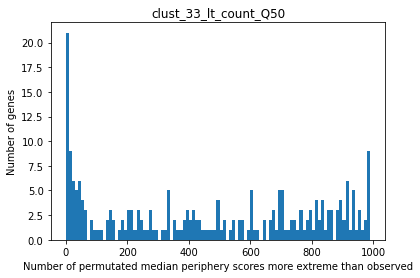

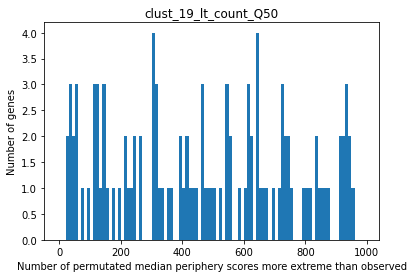

In [40]:
rows = [c for c in df.index if 'count_Q50' in c]
for row in rows:
    df.loc[row].plot.hist(bins=np.arange(0,1000,10))
    plt.title(row)
    plt.xlabel('Number of permutated median periphery scores more extreme than observed')
    plt.ylabel('Number of genes')
    plt.show()
    plt.close()

In [19]:
df.head()

,Cldn5,Col24a1,Blank-9,Camk2d,Plcxd3,Ankfn1,Blank-8,C1qtnf7,Egr2,Ikzf2,...,Marcksl1,Dscaml1,Vtn,Slc44a5,Tmtc2,Ccnb1,Cacng5,Blank-3,Fam84b,Fezf2
gene,,,,,,,,,,,,,,,,,,,,,
num_cells,3238.000000,6403.000000,4251.000000,19781.000000,14157.000000,5514.000000,5270.000000,1938.000000,10508.000000,10379.000000,...,13290.000000,19984.000000,7076.000000,9060.000000,15638.000000,4087.000000,8732.000000,3975.000000,12811.000000,13034.000000
real_Q25,0.109027,0.621071,0.357121,0.382998,0.343750,0.383723,0.309889,0.323393,0.439124,0.381283,...,0.297070,0.396678,0.226887,0.404934,0.348687,0.338986,0.323808,0.414308,0.345384,0.380055
real_Q50,0.345253,0.805838,0.621622,0.480506,0.492739,0.587525,0.557525,0.596202,0.659840,0.602165,...,0.429504,0.513833,0.477407,0.621212,0.544590,0.599781,0.512613,0.659731,0.516213,0.500000
real_Q75,0.660303,0.905948,0.831739,0.575935,0.636757,0.789254,0.795863,0.833018,0.832745,0.798409,...,0.547651,0.627884,0.720179,0.807268,0.723620,0.820092,0.701991,0.854632,0.673526,0.613082
overall_clusts_lt_count_Q25,0.000000,1000.000000,1000.000000,0.000000,0.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,0.000000,431.000000,0.000000,1000.000000,1000.000000,1000.000000,47.000000,1000.000000,121.000000,0.000000


In [22]:
df.index

Index(['num_cells', 'real_Q25', 'real_Q50', 'real_Q75',
       'overall_clusts_lt_count_Q25', 'overall_clusts_lt_count_Q50',
       'overall_clusts_lt_count_Q75', 'overall_clusts_Q25',
       'overall_clusts_Q50', 'overall_clusts_Q75',
       ...
       'clust_33_Q25', 'clust_33_Q50', 'clust_33_Q75', 'clust_19_cell_count',
       'clust_19_lt_count_Q25', 'clust_19_lt_count_Q50',
       'clust_19_lt_count_Q75', 'clust_19_Q25', 'clust_19_Q50',
       'clust_19_Q75'],
      dtype='object', name='gene', length=234)

In [31]:
df.head()

,Cldn5,Col24a1,Blank-9,Camk2d,Plcxd3,Ankfn1,Blank-8,C1qtnf7,Egr2,Ikzf2,...,Marcksl1,Dscaml1,Vtn,Slc44a5,Tmtc2,Ccnb1,Cacng5,Blank-3,Fam84b,Fezf2
gene,,,,,,,,,,,,,,,,,,,,,
num_cells,3238.000000,6403.000000,4251.000000,19781.000000,14157.000000,5514.000000,5270.000000,1938.000000,10508.000000,10379.000000,...,13290.000000,19984.000000,7076.000000,9060.000000,15638.000000,4087.000000,8732.000000,3975.000000,12811.000000,13034.000000
real_Q25,0.109027,0.621071,0.357121,0.382998,0.343750,0.383723,0.309889,0.323393,0.439124,0.381283,...,0.297070,0.396678,0.226887,0.404934,0.348687,0.338986,0.323808,0.414308,0.345384,0.380055
real_Q50,0.345253,0.805838,0.621622,0.480506,0.492739,0.587525,0.557525,0.596202,0.659840,0.602165,...,0.429504,0.513833,0.477407,0.621212,0.544590,0.599781,0.512613,0.659731,0.516213,0.500000
real_Q75,0.660303,0.905948,0.831739,0.575935,0.636757,0.789254,0.795863,0.833018,0.832745,0.798409,...,0.547651,0.627884,0.720179,0.807268,0.723620,0.820092,0.701991,0.854632,0.673526,0.613082
overall_clusts_lt_count_Q25,0.000000,1000.000000,1000.000000,0.000000,0.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,0.000000,431.000000,0.000000,1000.000000,1000.000000,1000.000000,47.000000,1000.000000,121.000000,0.000000


In [29]:
x.dropna().shape

(32,)

In [30]:
y.dropna().shape

(31,)

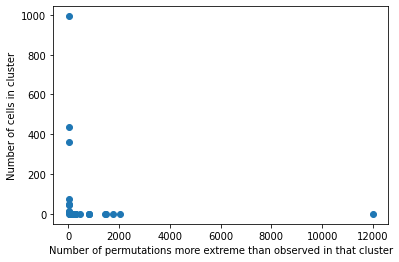

In [38]:
cell_count_rows = ['num_cells']+[c for c in df.index if 'cell_count' in c]

x = df['Ctss'].loc[cell_count_rows]
y = df['Ctss'].loc[rows]

plt.plot(x.dropna(),y.dropna(),'o')
plt.ylabel('Number of cells in cluster')
plt.xlabel('Number of permutations more extreme than observed in that cluster')
plt.show()
plt.close()